# Cancer PCA experiment 2

In [20]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn import random_projection
from cluster_func import em
from cluster_func import kmeans

In [21]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
# clean out '?' values
X = np.nan_to_num(X)

y = data.target

X_f = data.data
y_f = data.target

#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

Starting PCA
Dimensionality reduction


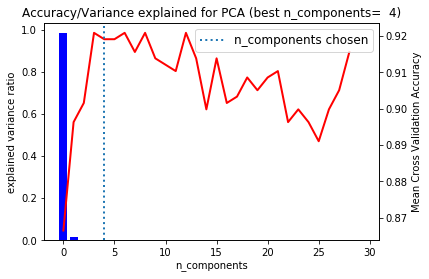

In [22]:
########################################################################################################################
########################################################################################################################
#Dimensionality reduction PCA


print("Starting PCA")
print("Dimensionality reduction")

decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
pca = PCA()

pipe = Pipeline(steps=[('pca', pca), ('decisionTree', decisiontree)])

# Plot the PCA spectrum
pca.fit(X)

fig, ax = plt.subplots()
#ax.bar(list(range(1,X.shape[1])), pca.explained_variance_ratio_, linewidth=2, color = 'blue')
ax.bar(np.arange(X.shape[1]), pca.explained_variance_ratio_, linewidth=2, color = 'blue')
plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('explained variance ratio')

#Checking the accuracy for taking all combination of components
n_components = range(1, X.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(pca__n_components=n_components), cv = 3)
gridSearch.fit(X, y)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/Variance explained for PCA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['pca'].n_components )
plt.show()

#Reducing the dimensions with optimal number of components
pca_new = PCA(n_components = gridSearch.best_estimator_.named_steps['pca'].n_components)
pca_new.fit(X_train)
X_train_transformed = pca_new.transform(X_train)
X_test_transformed = pca_new.transform(X_test)

Calculating Reconstruction Error


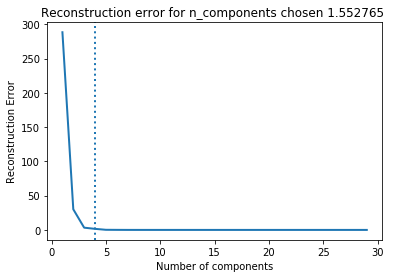

In [23]:
###############################################################################################################################
#Reconstruction Error

print("Calculating Reconstruction Error")


reconstruction_error = []
for comp in n_components:

	pca = PCA(n_components = comp)
	X_transformed = pca.fit_transform(X_train)
	X_projected = pca.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['pca'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Clustering PCA
Expected Maximization
Training accuracy for Expected Maximization for K = 2:  89.67032967032968
Testing accuracy for Expected Maximization for K = 2:  92.10526315789474
KMeans


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Training accuracy for KMeans for K = 2:  85.49450549450549
Testing accuracy for KMeans for K = 2:  85.08771929824562


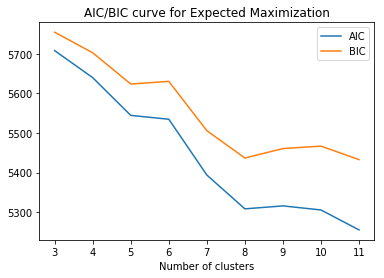

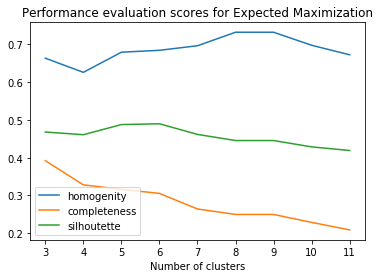

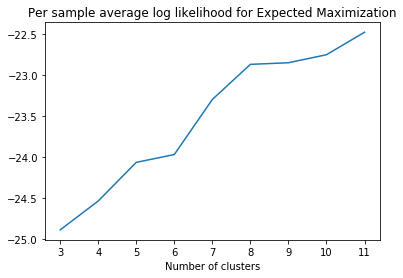

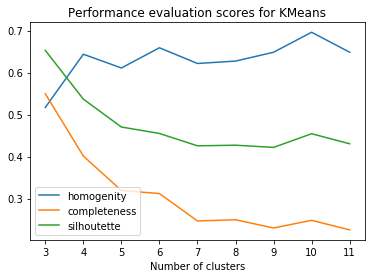

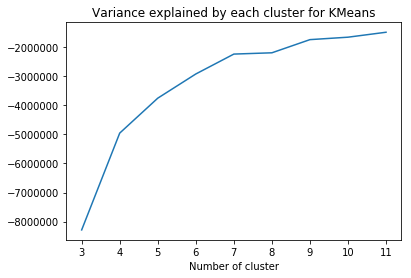

In [26]:
################################################################################################################################
#Clustering after dimensionality reduction

print("Clustering PCA")

#Reducing the dimensions with optimal number of components
pca_new = PCA(n_components = gridSearch.best_estimator_.named_steps['pca'].n_components)
pca_new.fit(X_f)
X_transformed_f = pca_new.transform(X_f)


means_init = np.array([X_transformed_f[y_f == i].mean(axis=0) for i in range(2)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow =0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow =0)

In [28]:
#Writing data to file
component_list = np.array(component_list).reshape(-1,1)
array_aic = np.array(array_aic).reshape(-1,1)
array_bic = np.array(array_bic).reshape(-1,1)
array_homo_1 = np.array(array_homo_1).reshape(-1,1)
array_comp_1 = np.array(array_comp_1).reshape(-1,1)
array_sil_1 = np.array(array_sil_1).reshape(-1,1)
array_avg_log = np.array(array_avg_log).reshape(-1,1)
array_homo_2 = np.array(array_homo_2).reshape(-1,1)
array_comp_2 = np.array(array_comp_2).reshape(-1,1)
array_sil_2 = np.array(array_sil_2).reshape(-1,1)
array_var = np.array(array_var).reshape(-1,1)

reconstruction_error = np.array(reconstruction_error).reshape(-1,1)

data_em_pca_cancer = np.concatenate((component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log), axis =1)

data_km_pca_cancer = np.concatenate((component_list, array_homo_2, array_sil_2, array_var), axis =1)

reconstruction_error_pca_cancer = np.concatenate((np.arange(1,X.shape[1]).reshape(-1,1), reconstruction_error), axis = 1)

file = './data/data_em_pca_cancer.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_em_pca_cancer)

file = './data/data_km_pca_cancer.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(data_km_pca_cancer)

file = './data/reconstruction_error_pca_cancer.csv'
with open(file, 'w', newline = '') as output:
	writer = csv.writer(output, delimiter=',')
	writer.writerows(reconstruction_error_pca_cancer)